<a href="https://colab.research.google.com/github/alysonnyang/sequential_recommendation/blob/main/cf_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! [ -e /content ] && pip install -Uqq fastbook
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# import fastbook
# fastbook.setup_book()

     |████████████████████████████████| 719 kB 18.8 MB/s 
     |████████████████████████████████| 4.9 MB 56.6 MB/s 
     |████████████████████████████████| 1.3 MB 64.7 MB/s 
     |████████████████████████████████| 365 kB 60.0 MB/s 
     |████████████████████████████████| 115 kB 77.0 MB/s 
     |████████████████████████████████| 120 kB 77.3 MB/s 
     |████████████████████████████████| 212 kB 73.9 MB/s 
     |████████████████████████████████| 127 kB 62.3 MB/s 
     |████████████████████████████████| 6.6 MB 59.9 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://ar

In [93]:
import fastbook
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib as mpl

plt.style.use(['dark_background'])
plt.rc('font', family='NanumBarunGothic') 
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
orders = pd.read_csv('/content/orders.csv',index_col=0)
products = pd.read_csv('/content/products.csv',index_col=0)
display(orders.head())
display(products.head())

,user,productId,purchase
0,0000718ff0321d940cfb87577bd2a0e2,249,1
1,000136bb9a5636770b1e8ed6dd915b58,231,1
2,000136bb9a5636770b1e8ed6dd915b58,240,1
3,000136bb9a5636770b1e8ed6dd915b58,299,1
4,000136bb9a5636770b1e8ed6dd915b58,576,1


,productId,productName
0,20,"쿨쓰루쓰루 파운데이션 SPF30, PA++ 021 에브리"
1,21,"쿨쓰루쓰루 파운데이션 SPF30, PA++ 020 캄다운"
2,22,"쿨쓰루쓰루 파운데이션 SPF30, PA++ 019 블라썸"
3,23,"쿨쓰루쓰루 파운데이션 SPF30, PA++ 013 포세린"
4,24,하이퍼오퓰런트글로 640 이브's 애플


In [4]:
orders = orders.merge(products)

In [5]:
tmp = np.unique(orders.user, return_counts=True)
tmp = [tmp[0][i] for i in range(len(tmp[0])) if tmp[1][i] == 1 ]
len(tmp)

91728

In [6]:
orders = orders[~orders.user.isin(tmp)]
len(orders)

364832

In [7]:
orders.loc[orders.purchase >5,'purchase'] = 5
print(sorted(orders.purchase.unique()))

[1, 2, 3, 4, 5]


In [8]:
users = sorted(orders.user.unique())
len(users)

96088

In [9]:
orders.purchase.max()

5

In [44]:
dataLoaders = CollabDataLoaders.from_df(orders, item_name='productName',rating_name='purchase', bs=64,valid_pct=0.1,seed=81)

In [45]:
dataLoaders.show_batch()

,user,productName,purchase
0,17f93539a69ccab63b43290875aef2ff,"톤업 베이스 데일리 쿠션 SPF50+, PA+++ 008 도화 리필 1EA",1
1,546ed681d5acc31629d1a3db52aafff1,"쿨쓰루쓰루 파운데이션 SPF30, PA++ 013 포세린",1
2,5da448f75d34ed2fb9549b88b60ff38b,하이퍼오퓰런트글로 611 마담엑스,1
3,65687a8c96fed76ed7b85636b19bee11,스윗다이아 172 웨딩부케,1
4,7915e6b6a87315b2f0617ff0078a3aa2,스윗다이아 158 코랄베이지,1
5,4e1d1ad650554b705a10ad66447a3dad,에어립스 814 뱀파이어,1
6,1d8489f3a2ddb138d0d0af0f3026c47a,에어립스 803 누드베이지,2
7,f57453f3aca1aff17414a3c5ffc959b8,"쿨쓰루쓰루 파운데이션 SPF30, PA++ 013 포세린",1
8,67993ad08b146dc3202020dd7643d771,"톤업 베이스 데일리 쿠션 SPF50+, PA+++ 008 도화 (본품+리필)",1
9,1df6b48b3701cb56cb82660abcafebff,"쿨쓰루쓰루 파운데이션 SPF30, PA++ 021 에브리",1


# EmbeddingNN

In [65]:
min_purchase = orders.purchase.min()
max_purchase = orders.purchase.max() + 0.5

nn_learn = collab_learner(dataLoaders, use_nn = True, emb_szs = {"user":5, "productName":5}, y_range = (min_purchase, max_purchase), metrics=rmse)

SuggestedLRs(valley=0.007585775572806597)


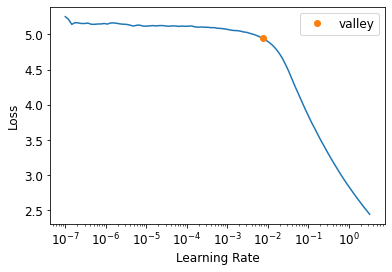

In [66]:
lr_valley = nn_learn.lr_find()
print(lr_valley)

In [67]:
set_lr = lr_valley[0]*1.1
print(set_lr)

0.008344353130087257


In [68]:
nn_learn.fit_one_cycle(5, set_lr)

epoch,train_loss,valid_loss,_rmse,time
0,0.076493,0.070025,0.264622,00:35
1,0.062834,0.068021,0.260808,00:34
2,0.075643,0.066976,0.258798,00:32
3,0.050167,0.068861,0.262413,00:33
4,0.058633,0.075580,0.274919,00:32


In [ ]:
nn_learn.export("/content/drive/MyDrive/BFactory/data/Neural_Network_model.pkl")

In [69]:
preds = nn_learn.get_preds()
rmse(preds[0],preds[1])
pred = pd.DataFrame(preds[0])
actual = pd.DataFrame(preds[1])
pred_error = actual - pred

In [70]:
print(f'min loss: {pred_error[0].min()}')
print(f'max loss: {pred_error[0].max()}')
loss_counter = Counter(pred_error[0].round())
display(loss_counter.most_common()[:5])

min loss: -2.4701132774353027
max loss: 3.9956417083740234


[(-0.0, 34258), (1.0, 1223), (-1.0, 822), (2.0, 130), (3.0, 30)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


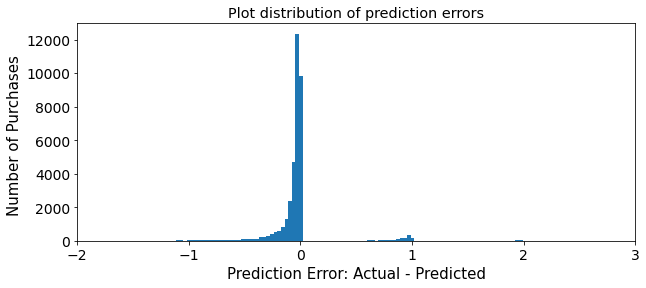

In [71]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax = plt.axes()
plt.hist(pred_error[0], bins=200)
ax.set_xlim([-2, 3])
plt.title('Plot distribution of prediction errors')
plt.xlabel('Prediction Error: Actual - Predicted', fontsize=15)
plt.ylabel('Number of Purchases ', fontsize=15)
plt.show()

In [72]:
u_ww = nn_learn.model.embeds[0].weight[1:].cpu().detach().numpy()
print(f'user_weight shape: {u_ww.shape}')
i_ww = (nn_learn.model.embeds[1].weight[1:].cpu().detach().numpy()).transpose()
print(f'item_weight shape: {i_ww.shape}')     

user_weight shape: (96088, 5)
item_weight shape: (5, 139)


In [73]:
matrix = pd.DataFrame(np.dot(u_ww, i_ww), index=dataLoaders.classes['user'][1:], columns=dataLoaders.classes['productName'][1:])

In [74]:
print(f'min value:{matrix.min().min()}')
print(f'max value:{matrix.max().max()}')
print(f'count of values over 1:{sum((matrix >=1).stack().values)}')

min value:-1.7722581624984741
max value:1.502035140991211
count of values over 1:302


In [75]:
predictions = matrix.stack()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


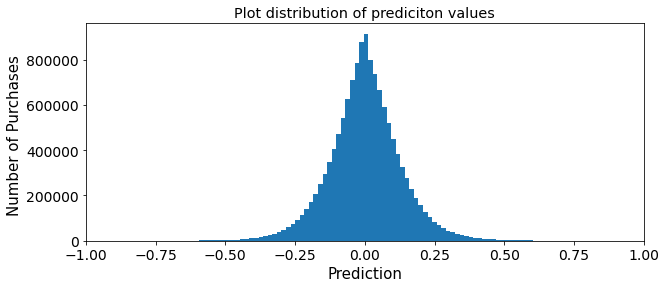

In [76]:
plt.figure(figsize=(10,4))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax = plt.axes()
plt.hist(predictions, bins=200)
ax.set_xlim([-1, 1])
plt.title('Plot distribution of prediciton values')
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Number of Purchases ', fontsize=15)
plt.show()

In [77]:
recommendation = pd.DataFrame(matrix.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5))

In [78]:
rec_counter = Counter(recommendation.stack())
rec_counter.most_common()[:10]

[('플랫립스 913 플라스틱오렌지', 48714),
 ('플랫립스 917 에프리콧치즈', 45580),
 ('스파클스팟 522 퍼플엔젤티얼스', 42204),
 ('스텝베이직 239 체스트넛', 33187),
 ('프리핏인앤아웃컨실러 006 라일락', 24755),
 ('에어립스 803 누드베이지', 22906),
 ('스텝베이직 229 살몬핑크', 22732),
 ('아스트랄라이트 005 딩키골드', 16269),
 ('비비드밤 406 츄잉핑크', 15836),
 ('플랫립스 906 로즈베이', 12083)]

# EmbeddingDotBias

In [79]:
learn = collab_learner(dataLoaders, n_factors=5, y_range=(0, 5.5))

In [80]:
learn.fit_one_cycle(5, set_lr)

epoch,train_loss,valid_loss,time
0,0.073244,0.070075,00:35
1,0.068734,0.069342,00:39
2,0.066542,0.077487,00:32
3,0.047106,0.081398,00:29
4,0.042881,0.086914,00:29


In [81]:
group = orders.groupby('productName')['purchase'].count()
top_products = group.sort_values(ascending=False).index.values
top_products[:10]

array(['스텝베이직 243 마카롱그레이', '스텝베이직 244 빈티지발렌타인', '톤업 베이스 데일리 쿠션 SPF50+, PA+++ 008 도화', '아멜리 스푸마토 브러시 01', '스텝베이직 219 발레리나', '베이크드파우더 003 밀키바이올렛', '플랫립스 914 뱀파이어', '스윗다이아 182 올댓누드', '스윗다이아 190 엔젤블러드',
       '스윗다이아 158 코랄베이지'], dtype=object)

In [82]:
product_bias = learn.model.bias(top_products, is_item=True)
product_bias.shape

torch.Size([139])

In [83]:
mean_orders = orders.groupby('productName')['purchase'].mean()
product_purchases = [(b, i, mean_orders.loc[i]) for i,b in zip(top_products,product_bias)]

In [84]:
print('worst bias')
display(sorted(product_purchases, key=lambda o:o[0])[:15])

print('best bias')
display(sorted(product_purchases, key=lambda o: o[0], reverse=True)[:15])

worst bias


[(tensor(-1.3490), '플랫립스 905 스칼렛', 1.015748031496063),
 (tensor(-1.3388), '스윗다이아 150 프레쉬라임', 1.0508474576271187),
 (tensor(-1.3340), '에어립스 806 로즈베이', 1.0114285714285713),
 (tensor(-1.3329), '스파클스팟 522 퍼플엔젤티얼스', 1.0196078431372548),
 (tensor(-1.3317), '비비드밤 406 츄잉핑크', 1.023391812865497),
 (tensor(-1.3309), '에어립스 813 플라스틱오렌지', 1.0187667560321716),
 (tensor(-1.3309), '비비드밤 403 시트러스옐로', 1.0075757575757576),
 (tensor(-1.3305),
  '톤업 베이스 데일리 쿠션 SPF50+, PA+++ 008 도화(본품+리필) + 리필 1EA',
  1.0246056782334385),
 (tensor(-1.3284), '하이퍼오퓰런트글로 636 치미레드', 1.0394736842105263),
 (tensor(-1.3269), '스텝베이직 019 오렌지망고', 1.032),
 (tensor(-1.3246), '에어립스 828 콜드블러드', 1.0311203319502074),
 (tensor(-1.3245), '스윗다이아 181 오렌지글로우', 1.025735294117647),
 (tensor(-1.3230), '에어립스 805 스칼렛', 1.0177215189873419),
 (tensor(-1.3224), '스텝베이직 217 챠콜브라운', 1.0226293103448276),
 (tensor(-1.3195), '에어립스 825 에브리데이', 1.0253164556962024)]

best bias


[(tensor(-0.1331), '립스틱스 914 뱀파이어', 1.0),
 (tensor(-1.0464), '쿨쓰루쓰루 파운데이션 SPF30, PA++ 021 에브리', 1.0923913043478262),
 (tensor(-1.0611), '스윗다이아 190 엔젤블러드', 1.07608786436148),
 (tensor(-1.0930), '스텝베이직 243 마카롱그레이', 1.083308053996663),
 (tensor(-1.0987), '톤업 베이스 데일리 쿠션 SPF50+, PA+++ 000 백설', 1.0955985421923184),
 (tensor(-1.0994), '톤업 베이스 데일리 쿠션 SPF50+, PA+++ 008 도화', 1.1507969222313823),
 (tensor(-1.1191),
  '내추럴 레이어링 쿠션 파운데이션 SPF50+, PA+++ 021 단아',
  1.0904522613065326),
 (tensor(-1.1273),
  '내추럴 레이어링 쿠션 파운데이션 SPF50+, PA+++ 019 화사',
  1.088797108931337),
 (tensor(-1.1280), '쿨쓰루쓰루 파운데이션 SPF30, PA++ 020 캄다운', 1.0859133126934986),
 (tensor(-1.1299), '말랑퍼프', 1.0747362774897193),
 (tensor(-1.1383), '스텝베이직 219 발레리나', 1.052103463653932),
 (tensor(-1.1460), '쿨쓰루쓰루 파운데이션 SPF30, PA++ 019 블라썸', 1.0799049457893954),
 (tensor(-1.1461), '쿨쓰루쓰루 파운데이션 SPF30, PA++ 013 포세린', 1.0904559270516718),
 (tensor(-1.1501),
  '내추럴 레이어링 쿠션 파운데이션 SPF50+, PA+++ 012 뽀얀',
  1.0973963355834138),
 (tensor(-1.1533), '스윗다이

In [85]:
product_w = learn.model.weight(top_products, is_item=True)
product_w.shape

torch.Size([139, 5])

In [86]:
product_pca = product_w.pca(3)
product_pca.shape

torch.Size([139, 3])

In [87]:
fac0,fac1,fac2 = product_pca.t()
product_compare = [(f, i) for f,i in zip(fac0, top_products)]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53597 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_

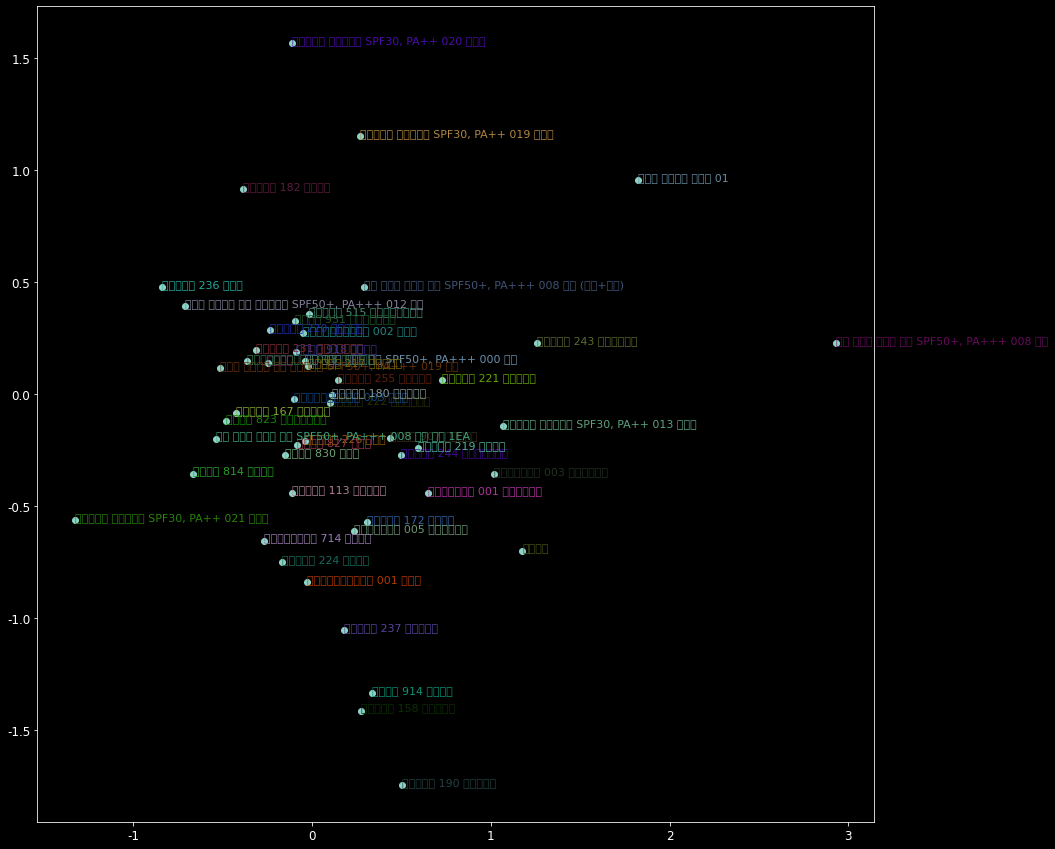

In [94]:
idxs = np.random.choice(len(top_products), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_products[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()